# Large Data Analytics 
## Part 1: Ordinary Least Squares

This is part 1 of ipython notebook that illustrates 'Large Data Analytics' talk given by *Todd Munson* and *Stefan Wild* using energy data from University of Chicago buildings.

## Sections
- [Introduction](#intro)
- [What is ordinary least square (OLS)](#ols-intro)
- [Dataset](#dataset)
- [Import data into ipython notebook](#import-data)
- [Pick building and term to work on](#building)
- [Calculating OLS using IPython](#ols)
    - [Example 1: Effect of Temperature on Energy Use](#ols)
        - [Basic Algorithm](#basic)
        - [First Algorithm for small variables](#first)
        - [Second Algorithm for small variables](#second)
        - [Comparison with inbuilt methods](#section)
    
    
-----------------

<a id='intro'></a>

## Introduction

<span style="color:red"> @Todd: Could you expand on some of this text? </span>

#### Where does big data come from?
- Companies like Google and Netflix
- Large data sets associated with network traffic
- Scientific applications like fluid flow simulations
- Measured data from sensors and experiments 

**In this illustration: we will use electricity meter data from University of Chicago buildings**

#### What do analysts do with big data?
- Marketing, making recommendations
- Estimating human behavior and finding anomalies
- System state estimation
- Inverse problems

#### How do we do it?
- Feature extraction and machine learning
- Regression models and classification
- Data assimilation

#### Why is big data hard?
- Real data is messy
- Online updates to the data
- Tradeoff complexity and data access
- Few complete passes through the data
- Sometimes access each piece of data only once
- May not look at some data at all


------------------------

<a id = 'ols-intro'></a>

## What is ordinary least square (OLS)?

<span style="color:red"> @Todd: could you expand here. </span>
- What is in layman (non mathematical :-) ) terms?
- What is its general purpose? 
- Where is it used?
- What are its limitations?


-----------------------

<a id='dataset'></a>

## Dataset

In 2015, the 160 campus buildings and grounds used $40 million worth of energy. Analyzing the data trends will help improve our understanding of campus energy usage and increase energy efficiency!

Dataset consists of the following:

- Campus electricity data for ## buildings (## meters) from 2014 to 2016, at 15 minute intervals.

- Weather station data for the same time interval


The files can be downloaded here:

<span style="color:red"> !! Radha will make shorter versions of the csv files and upload to this girhub repo !! </span> 

https://rdcep.squarespace.com/caal-activities/fall-hackathon-2016

Click on ***comed data*** for energy usage data and ***weather*** for temperature data.


--------------------

<a id='import-data'></a>

## Import data into ipython notebook

#### Import python libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

#### Read Files

In [2]:
df = pd.read_csv('uc_comed_two_years_final.csv', header = 'infer')

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_temp = pd.read_csv('weather_prepared_final.csv')

#### Keeping useful columns and converting date-time

In [4]:
df_new = df.filter(['DATETIME', 'TERM', 'BD_ID', 'DISCRIPT1', 'USAGE'])
df_new['DATETIME'] = pd.to_datetime(df_new['DATETIME'])
df_temp_new = df_temp.filter(['DATE', 'STATION', 'TEMPERATURE', 'HUMIDITY'])
df_temp_new['DATE'] = pd.to_datetime(df_temp_new['DATE'])

------------------

<a id='building'></a>

## Pick building and term to work on

#### Function to choose data based on term, building_name, and weather_station

In [5]:
def get_data(term, building_name, weather_station = 'Regenstein Library Weather Station'):
    ## PICK USAGE DATA BASED ON TERM AND BUILDING_NAME
    usage = df_new[(df_new['TERM'] == term) & (df_new['DISCRIPT1'] == building_name)]
    
    ## GET START AND END DATE OF THE TERM
    start_date = usage.iloc[0]['DATETIME']
    end_date = usage.iloc[-1]['DATETIME']
    
    ## PICK WEATHER STATION FOR TEMP
    df_T = df_temp_new[(df_temp_new['STATION'] == weather_station)]
    
    df_bool1 = (df_temp_new['DATE'] == start_date)
    index1 = df_bool1[df_bool1 == True].index.tolist()[0]
    
    df_bool2 = (df_temp_new['DATE'] == end_date)
    index2 = df_bool2[df_bool2 == True].index.tolist()[0]
    
    try: 
        temp = df_T.loc[index1:index2+1] 
    except:
        temp = df_T.loc[index1:end]
    
    usage_temp = pd.merge(left = usage, right = temp, left_on='DATETIME', right_on = 'DATE', how='left')
    return(usage_temp)

##### values for term, building_name, weather_station below

In [6]:
terms = df_new.TERM.unique()

In [7]:
building_names = df_new.DISCRIPT1.unique()

In [8]:
weather_stations = df_temp_new.STATION.unique()

#### Select TERM, BUILDING_NAME & Get Dataframe

In [9]:
usage_temp = get_data('Summer 2015', 'Regenstein Library', 'Regenstein Library Weather Station')

##### plot of Energy use vs time, Temperature vs time & Humidity vs time

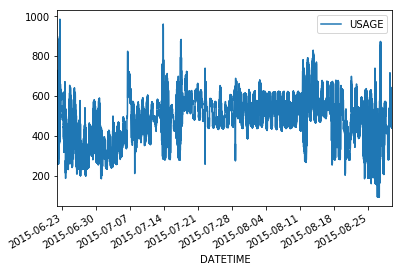

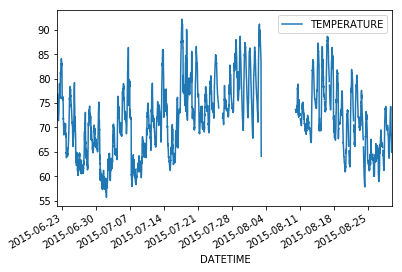

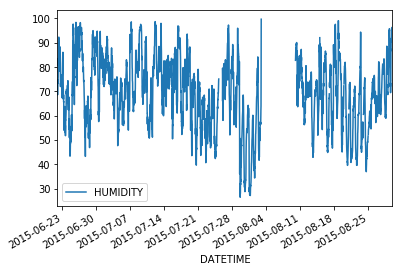

In [10]:
usage_temp.plot(x = 'DATETIME', y = 'USAGE')
usage_temp.plot(x = 'DATETIME', y = 'TEMPERATURE')
usage_temp.plot(x = 'DATETIME', y = 'HUMIDITY')

----------------

<a id='ols'></a>

# Calculating Ordinary Least Square using IPython:
## Example 1: Effect of temperature on energy use

Using university electricity data, we would like to find how temperature affects energy use. 

### Terminology 

<span style="color:red"> @Todd: does this section make sense? </span>

In this example, temperature is a **property** that affects our **observation**, energy use. A **model** is a relationship that describes how a property might affect the observation. Model consists of **coefficients**, which are multiplicative factors for properties. That is, 

***Model: coefficient x property = model_observation*** 

We would like to get the **model_observation** to be as close to the real observation as possible. This is achieved by appropriately varying the coefficient values. The best possible set of coefficient values will have the least amount of difference between the model_observation and real observation. 

### Data Representation

<span style="color:red"> @Todd: does this section make sense? </span>

- A is a column of property (temperature)
- b is a column of observation (energy use) 
- Model: Ax
    - x is the coefficient array that we will calculate
- y is the residual
    - this is the difference between the observation predicted by the model (Ax) and the actual value of observation (b)
    - Hence, \\(y = Ax - b\\)

Mathematically, Ordinary Least Square (OLS) amounts to minimizing the following

<span style="color:red"> @Todd: need your help explaining this.. </span>
Minimizing two norm: 

\\(\parallel y \parallel_2^2  =  \sum_i y_i^2 \\)

\\(\underset{x}{\min} \parallel Ax − b \parallel^2 \\)



  Data representation: A ∈ Rm×n
  Vector of observations: b ∈ Rn
  m is the number of measurements
  n is the number of variables
  Both can be very large

### Step 1: Cleaning the data

As mentioned earlier, real data can be messy. In our example, if we look at the plots of temperature vs time and humdity vs time, we see that for some chunk of dates, we have no observations. We will start by dropping those dates from our calculations. 

In [11]:
usage_temp = usage_temp.dropna(subset = ['TEMPERATURE', 'HUMIDITY'])
## droppin NaN values

### Step 2: Creating column A (column of property: temperature)

In [ ]:
A = np.array(usage_temp['TEMPERATURE'])
A

### Step 3: Creating column b (column of observation: energy use)

In [ ]:
b = np.array(usage_temp['USAGE'])
b

<a id = "basic"></a>

## The basic algorithm

To calculate x, here is the basic algorithm

<span style="color:red"> @Todd: need your help explaining this.. </span>

\\(x = (A^T A)^{-1} A^T b\\)

- Standard errors use \\(diag((A^T A)^{−1})\\)   
- Two cases
  - Number of variables is small
  - Number of variables is large -- we will ignore large
  
### Step 4: Calculating x and standard errors using basic algorithm

In [ ]:
Aprime = A.conj().T
x = la.lstsq(Aprime.dot(A), Aprime.dot(b))
x[0]

In [ ]:
B = Aprime.dot(A)
stderrs = np.diag(la.inv(B))
stderrs

<a id = "first"></a>

## Algorithm for small number of variables

<span style="color:red"> @Todd: need your help explaining this.. </span>
<span style="color:red"> Why is this preferred for small variables? </span>

  - Form the matrix \\(B = A^T A\\)
  - Requires O(mn2) operations
  - Control roundoff errors for large m
  - Dense linear algebra
  - Form the inverse of B
    - Requires O(n3) operations
  - Control roundoff errors for large m
  - Dense linear algebra
  - Solve
  - \\(x=B^{-1} A^T b\\)
    - Requires O(n3 + mn) operations
  - Dense linear algebra
  - Compute standard errors using \\(diag(B^{−1} )\\)
  
### Step 5: Calculating x and standard errors using algorithm for small number of variables

In [14]:
Aprime = A.conj().T
x = la.lstsq(Aprime.dot(A), Aprime.dot(b))
x[0]

array([ 6.99019751, -0.30183171])

In [16]:
B = Aprime.dot(A)
stderrs = np.diag(la.inv(B))
stderrs

array([  4.48884136e-07,   4.62226476e-07])

<a id = "second"></a>

## Second Algorithm for small number of variables

<span style="color:red"> @Todd: need your help explaining this.. </span>
<span style="color:red"> What is the difference between these two algorithms? </span>

   - Form the matrix \\(B = A^T A\\)

     - Requires O(mn2) operations
  - Control roundoff errors for large m
  - Compute Cholesky factorization \\(B = L^T L\\) for lower triangular L
  - Solve \\(x = L^{−1} L^{−T} A^T b\\)
  - Compute standard errors (how?)
  
### Step 6: Calculating x and standard errors using second algorithm for small number of variables

In [17]:
L = la.cholesky(B).T
## cholesky factorization of a matrix (chol(a) in matlab 
## returns an upper triangular matrix, 
## but linalg.cholesky(a) returns a lower triangular matrix)
Lprime = L.conj().T
Lprime

array([[ 5513.38142522,     0.        ],
       [ 5230.34430161,  1470.86424481]])

In [18]:
x = la.lstsq(L, la.lstsq(Lprime, Aprime.dot(b))[0])
x[0]

array([ 6.99019751, -0.30183171])

<a id= "compare"></a>

## Comparison with inbuilt methods

to do .. 

------------------------

------------------------

## Work in progress....

In [12]:
A1 = np.array(usage_temp['TEMPERATURE'])
A2 = np.array(usage_temp['HUMIDITY'])
A = np.column_stack((A1,A2))


In [13]:
b = np.array(usage_temp['USAGE'])

### Todd's notes
Basic Algorithm

- Assuming A has full column rank

\\(x = (A^T A)^{-1} A^T b\\)

where \\(A^T A \in R^{n×n}\\) is symmetric

- Standard errors use \\(diag((A^T A)^{−1})\\)   
- Two cases
  - Number of variables is small
  - Number of variables is large -- we will ignore large
  
##### Matlab

x = (A' \* A) \\(A’ \* b);

stderrs = diag(inv(A’ \* A));

### Todd's notes
Generalized Least Squares

##### Matlab code

Give the previosly defined A and b,

B = A’ \* (Sigma \\A);

L = chol(B);

x = L \\(L’ \\(A’ * (Sigma \\b)));


In [19]:
Sigma = np.corrcoef(A1, A2)
Sigma

array([[ 1.        , -0.53512818],
       [-0.53512818,  1.        ]])

In [20]:
B = Aprime.dot(la.lstsq(Sigma, A))

LinAlgError: Incompatible dimensions